# 信用贷款违约预测

项目背景： 对用户贷款是否会违约进行预测，是一个二分类问题，比赛提供的信息有用户的个人属性(性别，职业，是否有车，是否有房，房子面积等)、历史贷款申请和信用局等信息。

 项目流程： 
 
    1.数据探索及清洗：查找数据集中的缺失值、异常值情况并进行处理；探索违约用户和非违约用户特征的分布情况；
    2.特征工程：从用户个人信息和行为两个角度来建立特征，对特征数据编码，筛选特征；
    3.采用lightgbm模型进行建模预测。

In [1]:
# 加载基本的python包，设置绘图格式
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
color  = sns.color_palette()
import plotly
import plotly.graph_objs as go #导入绘图工具
import plotly.offline as of 
from plotly.offline import init_notebook_mode,iplot
plotly.offline.init_notebook_mode(connected = True)
plt.style.use('fivethirtyeight')

1.数据探索及清洗

In [44]:
# 载入数据
app_train = pd.read_csv('file:///D:/kaggle比赛/信用贷款违约预测/application_train.csv')
app_test = pd.read_csv('file:///D:/kaggle比赛/信用贷款违约预测/application_test.csv')
bureau = pd.read_csv('file:///D:/kaggle比赛/信用贷款违约预测/bureau.csv')
previous_application = pd.read_csv('file:///D:/kaggle比赛/信用贷款违约预测/previous_application.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#定义缺失值检测函数
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 *  df.isnull().sum() / len(df)  #做百分比
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis = 1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0:'Missing Value',1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending = False).round(1)
    
    print('You selected dataframe has' + str(df.shape[1]) + 'columns.\n' 'Trere are ' + str(mis_val_table_ren_columns.shape[0])
          + 'columns that have missing values') 
    return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)  # 查看缺失比例前20的字段

You selected dataframe has122columns.
Trere are 67columns that have missing values


,Missing Value,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [8]:
#异常值探索   年龄分布较为正常
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [9]:
#工作时间，存在异常值
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

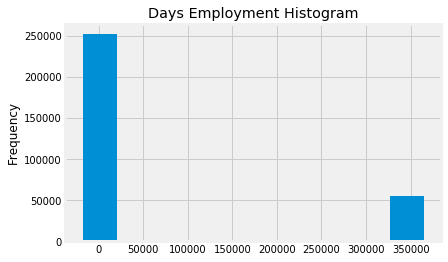

In [10]:
# 可视化工作时间
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

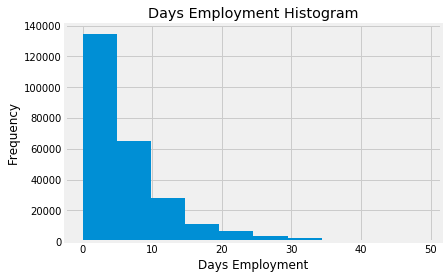

In [11]:
# 异常值理解为缺失值，故用nan值替代
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
(app_train['DAYS_EMPLOYED']/-365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [14]:
# 探索违约用户和非违约用户的特征分布情况
#用户特征绘图函数
def plot_stats(feature,label_rotation = False,horizontal_layout = True):
    temp = app_train[feature].value_counts()  #value_counts() 会自动计算出该组数据下各类别的数量,并且以各类名作为索引值
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    cat_perc = app_train[[feature,'TARGET']].groupby(feature,as_index = False).mean()  #TARGET只有0和1俩数，取平均即为算百分比
    cat_perc.sort_values(by = 'TARGET',ascending = False,inplace = True)
    if(horizontal_layout):
        fig,(ax1,ax2) = plt.subplots(ncols = 2,figsize = (12,6))
    else:
         fig,(ax1,ax2) = plt.subplots(nrows = 2,figsize = (12,14))
    sns.set_color_codes('pastel')
    s = sns.barplot(ax = ax1,x = feature,y = 'Number of contracts',data = df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation = 90)
    s= sns.barplot(ax = ax2,x= feature,y = 'TARGET',order = cat_perc[feature],data = cat_perc) #order 用于条形图x轴的显示顺序
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation = 90)
    plt.ylabel('Percent of target with value 1 [%]',fontsize = 10)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 10)
    plt.show()

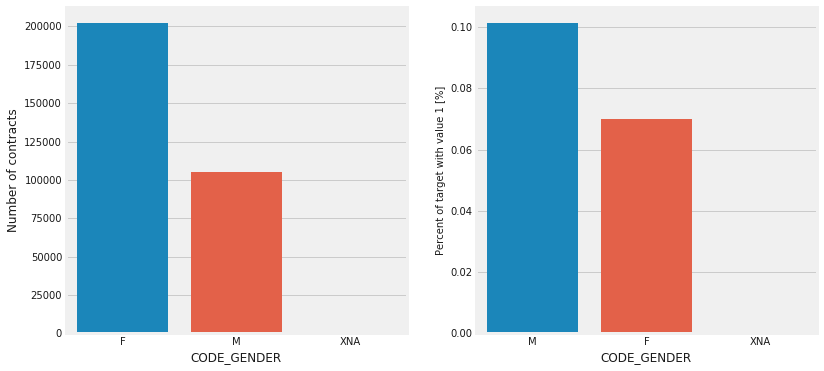

In [15]:
#性别差异
plot_stats('CODE_GENDER')

发现男女用户的违约情况：男性贷款合同更多，违约率也更高，男性违约率在10%，女性在7%。

C:\Users\tt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'Distribution of Age')

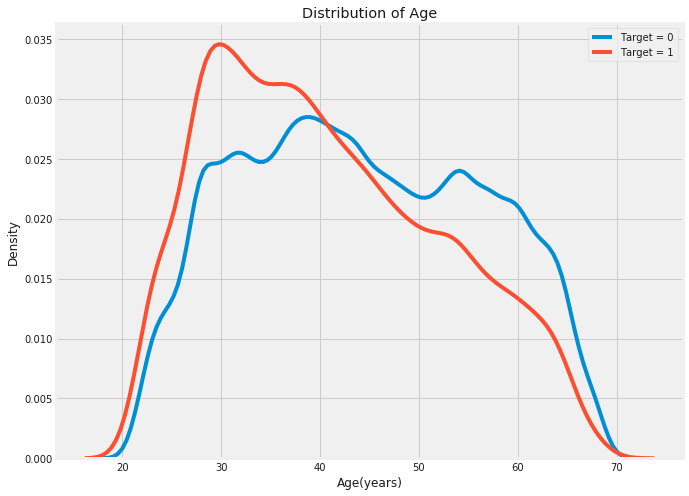

In [16]:
#年龄差异
plt.figure(figsize = (10,8))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0,'DAYS_BIRTH'] / -365,label = 'Target = 0') #未违约情况
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1,'DAYS_BIRTH'] / -365,label = 'Target = 1')  #违约情况
plt.xlabel('Age(years)'); plt.ylabel('Density'); plt.title('Distribution of Age')

通过上图分析可知，用户年龄较小的（30岁左右）违约可能性较大。

C:\Users\tt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tt\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,1,'Failure to Repay(%) by Age Group')

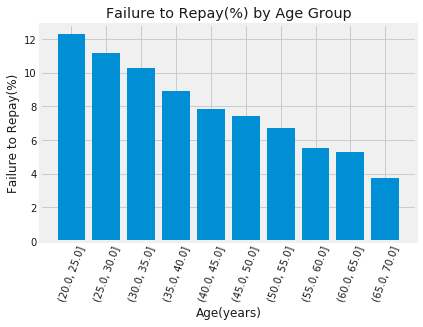

In [17]:
# 对年龄分桶，进一步观察不同年龄段用户的违约率情况
age_data = app_train[['DAYS_BIRTH','TARGET']] 
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins = np.linspace(20,70,num = 11))
age_groups = age_data.groupby('YEARS_BINNED').mean()* 100
plt.bar(age_groups.index.astype(str),age_groups['TARGET'])

plt.xticks(rotation = 70);plt.xlabel('Age(years)');plt.ylabel('Failure to Repay(%)')
plt.title('Failure to Repay(%) by Age Group')

从上图可以看出，年龄越小违约概率越大。

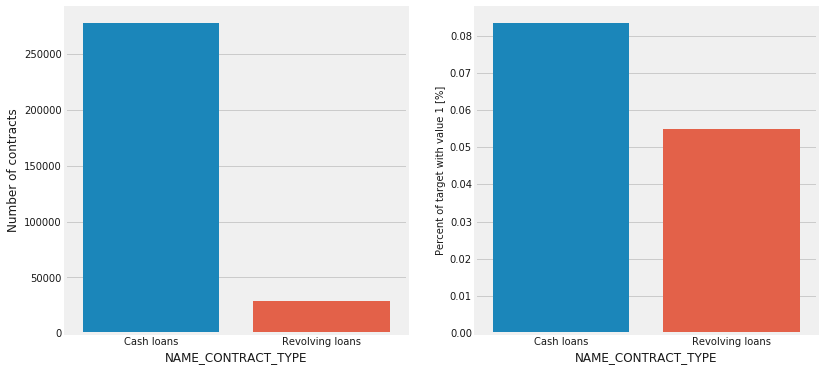

In [18]:
#对不同贷款类型的违约概率进行查看。可以发现现金贷款的违约概率更高。
plot_stats('NAME_CONTRACT_TYPE')

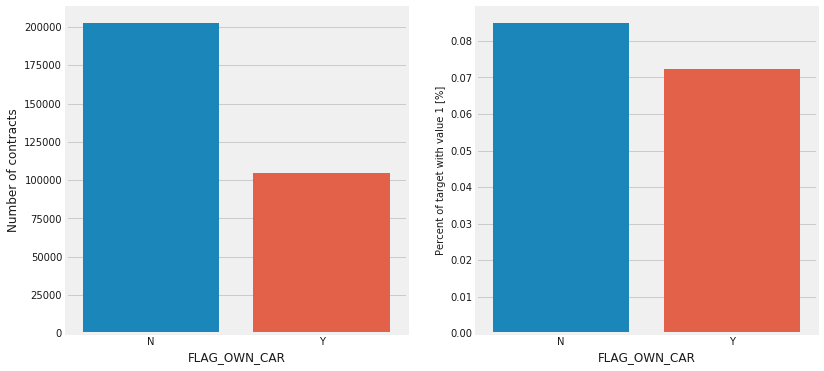

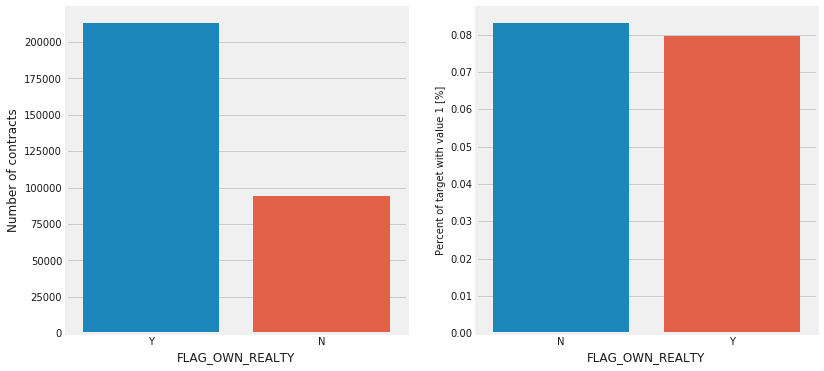

In [19]:
#是否有房和车对违约的影响
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

发现用户没有车和房子的违约概率更高，但相差不大。

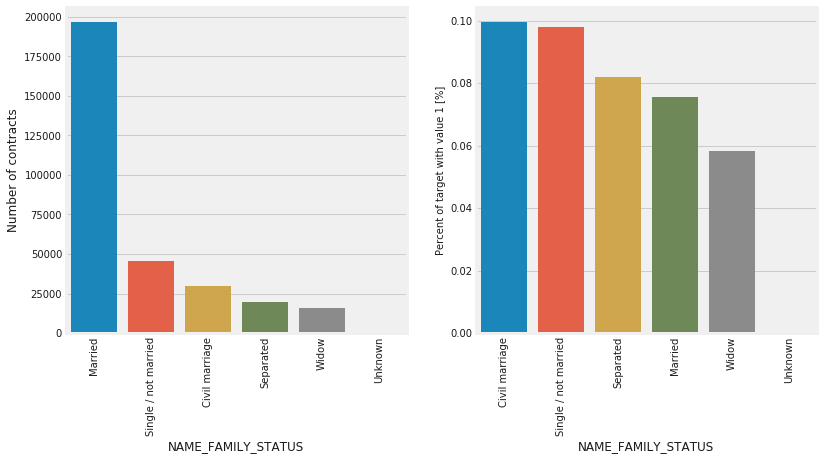

In [20]:
# 家庭情况
plot_stats('NAME_FAMILY_STATUS',True, True)

从家庭情况看，申请的用户大多已经结婚，单身和世俗结婚的违约率较高，寡居的违约率最低。

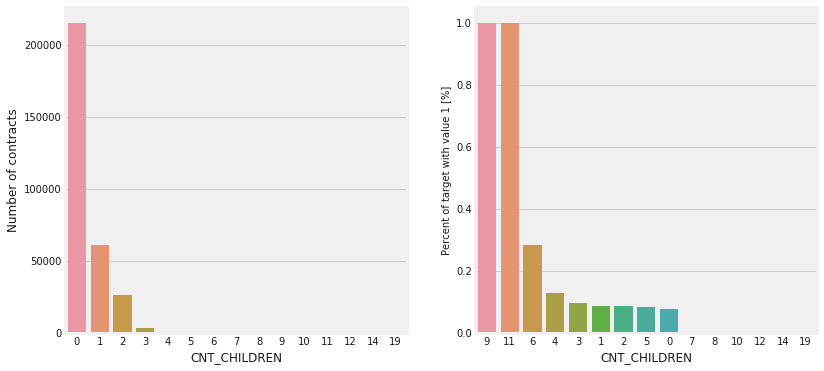

In [21]:
# 家庭子女情况
plot_stats('CNT_CHILDREN')

由上图可以发现大部分人没有孩子或者在3个一下，孩子越多违约率越高，有9个或11个孩子的违约率为100%。

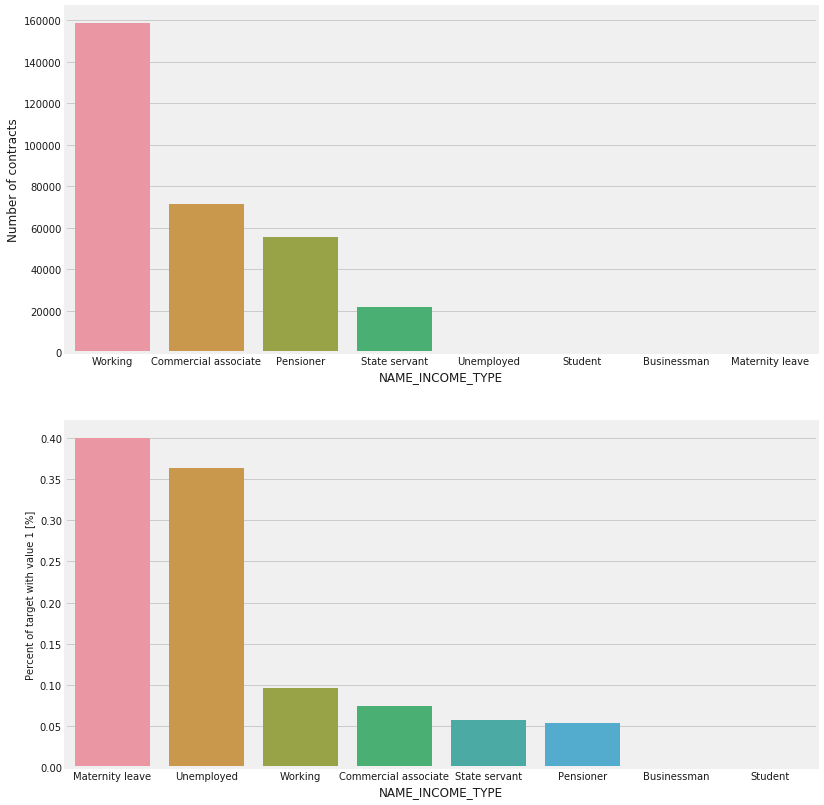

In [22]:
# 收入类型
plot_stats('NAME_INCOME_TYPE',False,False)

根据申请者的收入类型区分，可以发现休产假和没有工作的人违约率较高，在35%以上，对于这两类人群放款需较为谨慎。

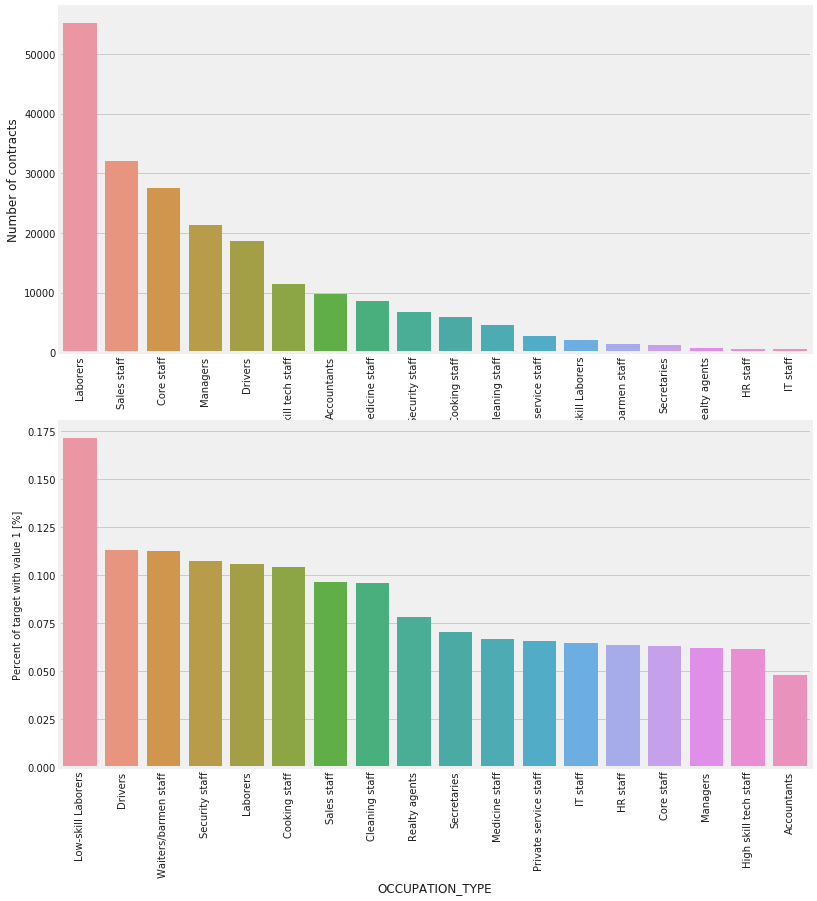

In [23]:
#职业情况
plot_stats('OCCUPATION_TYPE',True, False)

从职业来看，越相对收入较低、不稳定的职业违约率越高，比如低廉劳动力、司机、理发师，而像会计、高科技员工等具有稳定高收入的职业违约率就较低。

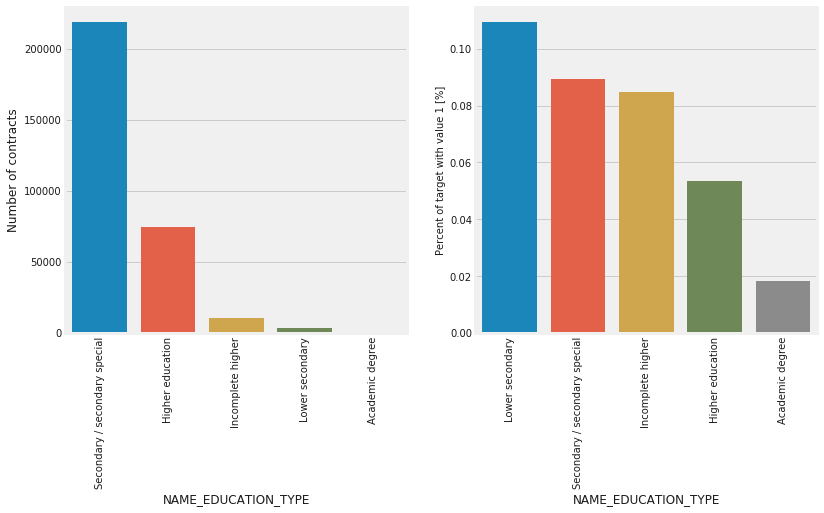

In [24]:
# 受教育情况
plot_stats('NAME_EDUCATION_TYPE',True)

贷款申请人受教育程度大多为中学，学历越低越容易违约。

2.特征工程

设计特征：
CREDIT_INCOME_PERCENT: 贷款金额/客户收入，预期是这个比值越大，说明贷款金额大于用户的收入，用户违约的可能性就越大

ANNUITY_INCOME_PERCENT: 贷款的每年还款金额/客户收入，逻辑与上面一致

CREDIT_TERM: 贷款的每年还款金额/贷款金额，贷款的还款周期，猜测还款周期短的贷款，用户的短期压力可能会比较大，违约概率高

DAYS_EMPLOYED_PERCENT: 用户工作时间/用户年龄

INCOME_PER_CHILD：客户收入/孩子数量，孩子很多，违约的可能性可能更高

HAS_HOUSE_INFORMATION : 客户是否有缺失房屋信息设计一个二分类特征，如果未缺失的话是1，缺失的是0

In [25]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['INCOME_PER_CHILD'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_CHILDREN']
app_train['HAS_HOUSE_INFORMATION'] = app_train['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)


app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['INCOME_PER_CHILD'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_CHILDREN']
app_test['HAS_HOUSE_INFORMATION'] = app_test['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

C:\Users\tt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\tt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

C:\Users\tt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in less



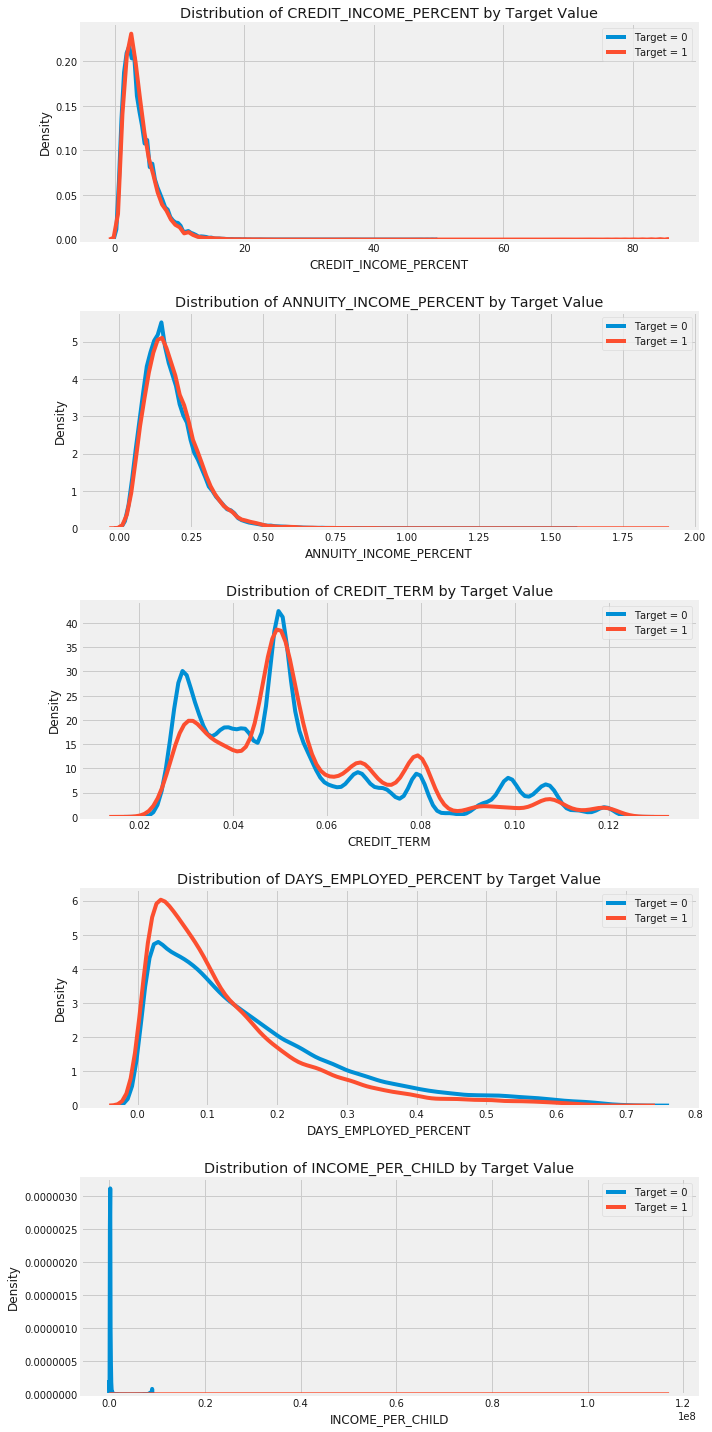

In [26]:
#将上述特征可视化
plt.figure(figsize = (10,20))
for i,figure in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT','INCOME_PER_CHILD']):
    plt.subplot(5,1,i+1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0,figure],label = 'Target = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1,figure],label = 'Target = 1')
    plt.xlabel('%s' %figure)
    plt.ylabel('Density')
    plt.title('Distribution of %s by Target Value' %figure)
plt.tight_layout(h_pad = 2.5) #设置图标间隔

In [27]:
def plot_stats1(feature,label_rotation = False,horizontal_layout = True):
    temp = app_train[feature].value_counts()  #value_counts() 会自动计算出该组数据下各类别的数量,并且以各类名作为索引值
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    cat_perc = app_train[[feature,'TARGET']].groupby(feature,as_index = False).mean()  #TARGET只有0和1俩数，取平均即为算百分比
    cat_perc.sort_values(by = 'TARGET',ascending = False,inplace = True)
    if(horizontal_layout):
        fig,(ax1,ax2) = plt.subplots(ncols = 2,figsize = (12,6))
    else:
         fig,(ax1,ax2) = plt.subplots(nrows = 2,figsize = (12,14))
    sns.set_color_codes('pastel')
    s = sns.barplot(ax = ax1,x = feature,y = 'Number of contracts',data = df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation = 90)
    s= sns.barplot(ax = ax2,x= feature,y = 'TARGET',order = cat_perc[feature],data = cat_perc) #order 用于条形图x轴的显示顺序
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation = 90)
    plt.ylabel('Percent of target with value 1 [%]',fontsize = 10)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 10)
    plt.show()

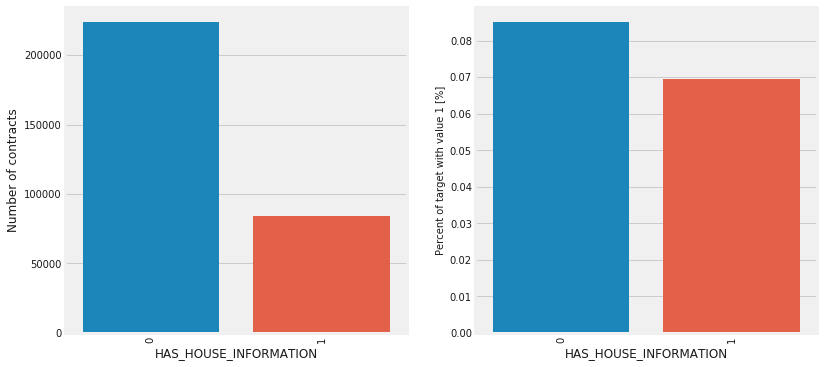

In [28]:
#拥有房屋信息的情况，缺失房屋信息的用户违约率要高于未缺失房屋信息的用户。
plot_stats1('HAS_HOUSE_INFORMATION',True)

In [39]:
# 定义连续型变量特征提取函数
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() # 计算统计特征
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))  #重命名
    agg.columns = columns
    return agg

In [40]:
# 定义离散型变量特征提取函数
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object')) #数据转变为哑变量
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))  #重命名
    categorical.columns = column_names
    return categorical

In [45]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head() 

C:\Users\tt\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [49]:
bureau_counts.head() 

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [46]:
#整合数据
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')

In [47]:
print(app_train.shape)
print(app_test.shape)

(307511, 228)
(48744, 227)


In [48]:
previous_appication_counts = count_categorical(previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
previous_appication_agg_new = agg_numeric(previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
previous_appication_agg_new.head()


C:\Users\tt\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,...,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [50]:
previous_appication_counts.head()

,previous_application_NAME_CONTRACT_TYPE_Cash loans_count,previous_application_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_application_NAME_CONTRACT_TYPE_XNA_count,previous_application_NAME_CONTRACT_TYPE_XNA_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


In [51]:
app_train = app_train.merge(previous_appication_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_appication_agg_new, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_appication_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_appication_agg_new, on = 'SK_ID_CURR', how = 'left')
print(app_train.shape)
print(app_test.shape)

(307511, 609)
(48744, 608)


In [ ]:
# 特征筛选：采用皮尔逊相关系数排除多重共线性特征
corrs = app_train.corr()
threshold = 0.8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

In [54]:
for key,value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove： ',len(cols_to_remove))

Number of columns to remove：  187


In [55]:
#从数据集中移除对应的列
train_corrs_removed = app_train.drop(columns = cols_to_remove)
test_corrs_removed = app_test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 422)
Testing Corrs Removed Shape:  (48744, 421)


3.建模预测

In [56]:
from sklearn.model_selection import KFold #划分互斥子集，交叉采样
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc # 垃圾回收机制

In [57]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        cat_indices = 'auto'
    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    feature_names = list(features.columns)
    features = np.array(features)
    test_features = np.array(test_features)
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):
        
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    valid_auc = roc_auc_score(labels, out_of_fold)
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [58]:
submission, fi, metrics = model(train_corrs_removed, test_corrs_removed)
print('Baseline metrics')
print(metrics)


Training Data Shape:  (307511, 541)
Testing Data Shape:  (48744, 541)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.820599	train's binary_logloss: 0.52608	valid's auc: 0.773331	valid's binary_logloss: 0.543966
[400]	train's auc: 0.855508	train's binary_logloss: 0.488854	valid's auc: 0.774797	valid's binary_logloss: 0.520292
Early stopping, best iteration is:
[427]	train's auc: 0.859525	train's binary_logloss: 0.48435	valid's auc: 0.775064	valid's binary_logloss: 0.517396
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.820795	train's binary_logloss: 0.525721	valid's auc: 0.772678	valid's binary_logloss: 0.543782
[400]	train's auc: 0.856528	train's binary_logloss: 0.487167	valid's auc: 0.773299	valid's binary_logloss: 0.519864
Early stopping, best iteration is:
[319]	train's auc: 0.843527	train's binary_logloss: 0.50136	valid's auc: 0.773423	valid's binary_logloss: 0.528743
Training until validation scores don't impr

In [60]:
submission.to_csv('D:/kaggle比赛/信用贷款违约预测/submission.csv',index=False)